## Import packages

In [1]:
library(forecast)
library(tseries)
library(lmtest)
library(Hmisc)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units



## Data

In [2]:
data <- read.csv("salary.csv", sep=",")

In [3]:
data <- read.csv("salary.csv", sep=",")
data$date = as.Date(as.yearmon(data$date, format="%Y/%m"))
data$salary = as.double(data$salary)

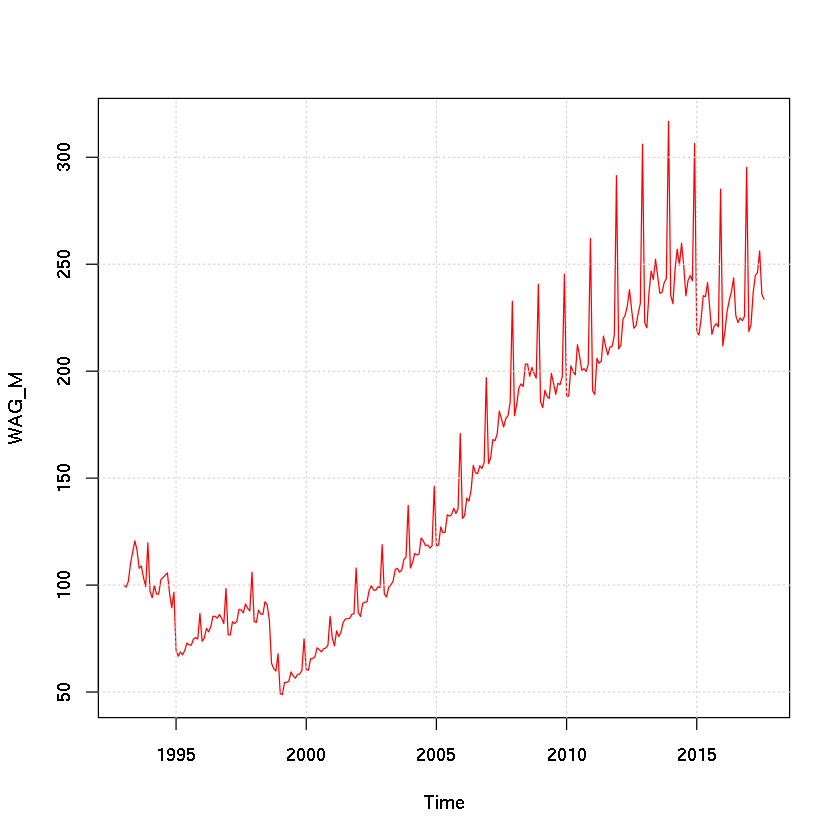

In [4]:
tSeries <- ts(data = data$salary, start = as.numeric(c(format(data$date[1], "%Y"), format(data$date[1], "%m"))), freq = 12)

xname <- "WAG_M"
plot(tSeries, type="l", ylab=xname, col="red")
grid()

trainSeries <- window(tSeries, end=c(2015,12))
testSeries  <- window(tSeries, start=c(2016,1))
D <- 24

## STL-decomposition of time series

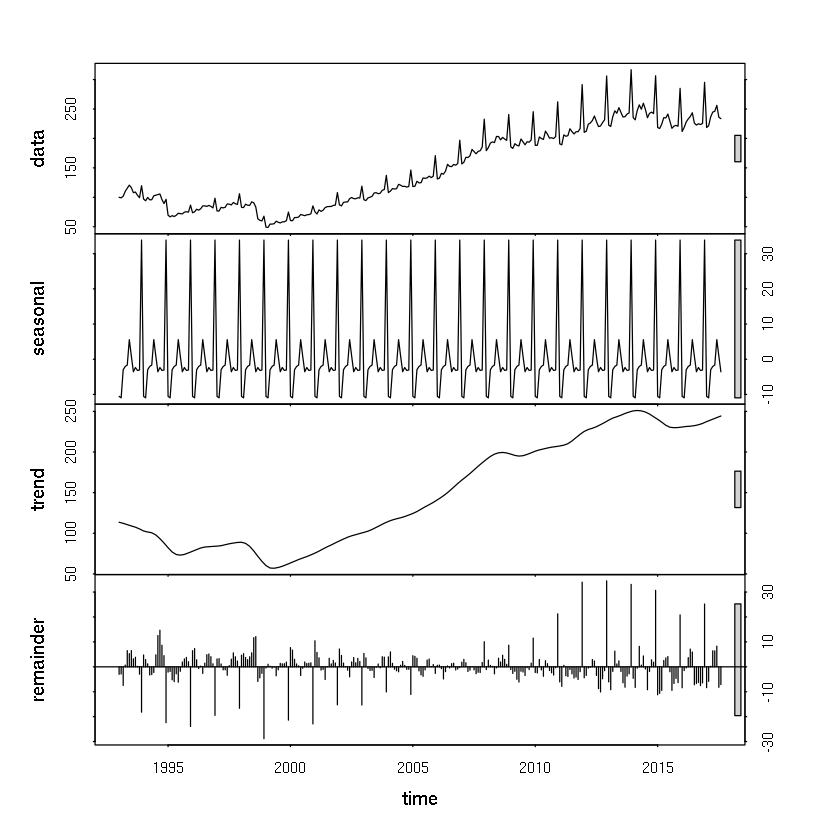

In [5]:
plot(stl(tSeries, s.window="periodic"))

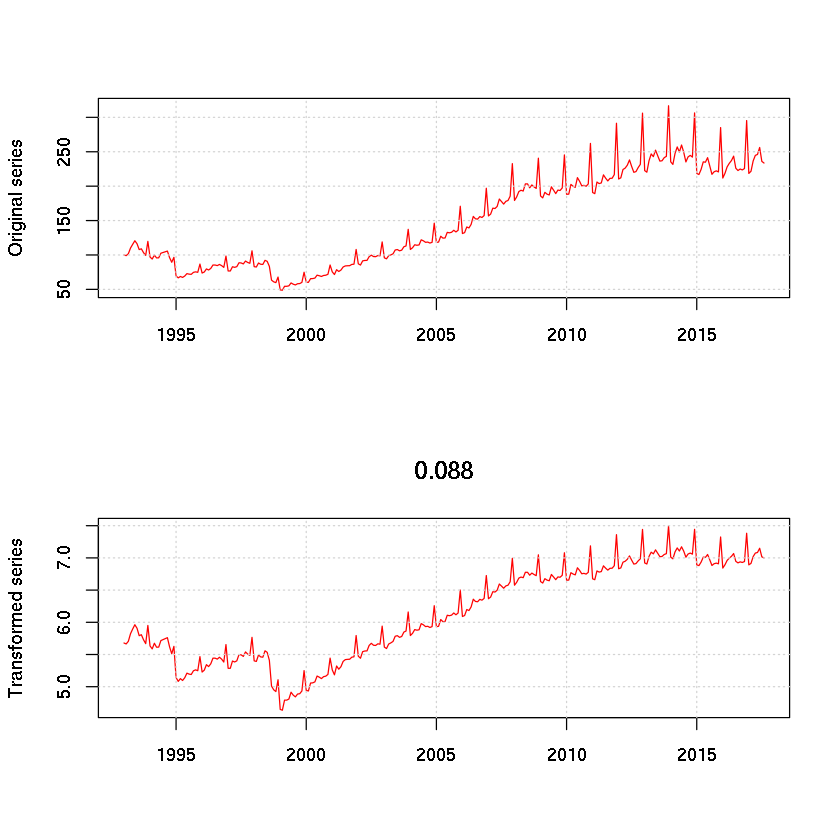

In [6]:
par(mfrow=c(2,1))
plot(tSeries, ylab="Original series", xlab="", col="red")
grid()

LambdaOpt <- BoxCox.lambda(tSeries)
plot(BoxCox(tSeries, LambdaOpt), ylab="Transformed series", xlab="", col="red")
title(main=toString(round(LambdaOpt, 3)))
grid()

## ARIMA

###  Auto selection

In [7]:
fit.auto <- auto.arima(tSeries, lambda=LambdaOpt)
fit.auto

Series: tSeries 
ARIMA(1,1,1)(2,1,2)[12]                    
Box Cox transformation: lambda= 0.08800602 

Coefficients:
         ar1      ma1     sar1    sar2    sma1     sma2
      0.7396  -0.5959  -0.7157  0.0272  0.0433  -0.4476
s.e.  0.1351   0.1597   0.3658  0.1019  0.3612   0.2170

sigma^2 estimated as 0.002354:  log likelihood=454.48
AIC=-894.95   AICc=-894.55   BIC=-869.44

ARIMA(1, 1, 1)(2, 1, 2)[12] is suggested. <br>
It's residuals:

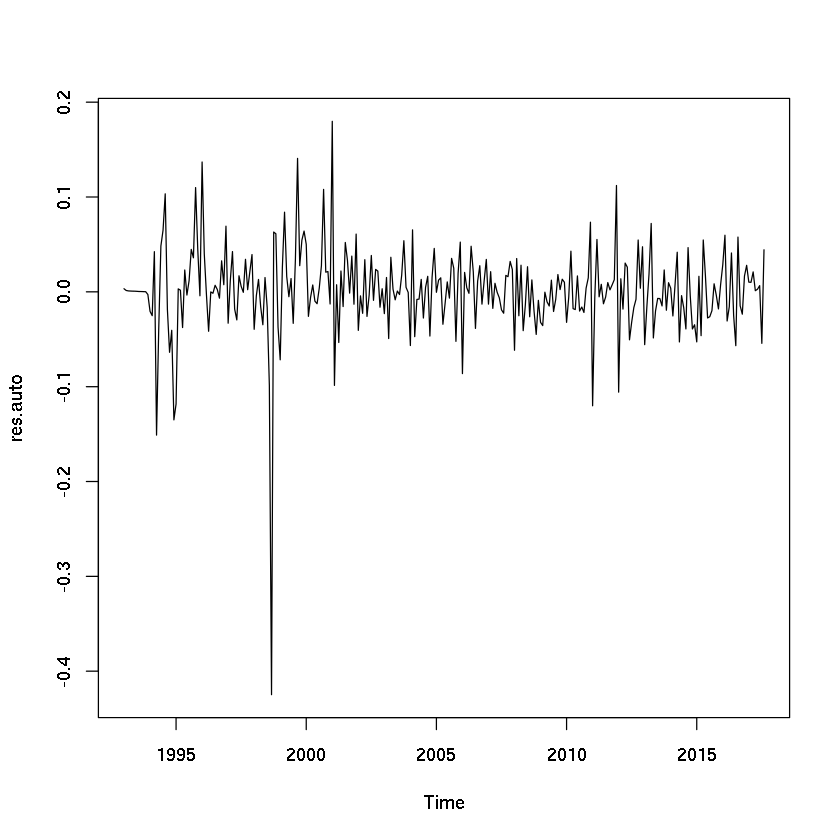

In [8]:
res.auto <- residuals(fit.auto)
plot(res.auto)

Let's remove first 70 values:

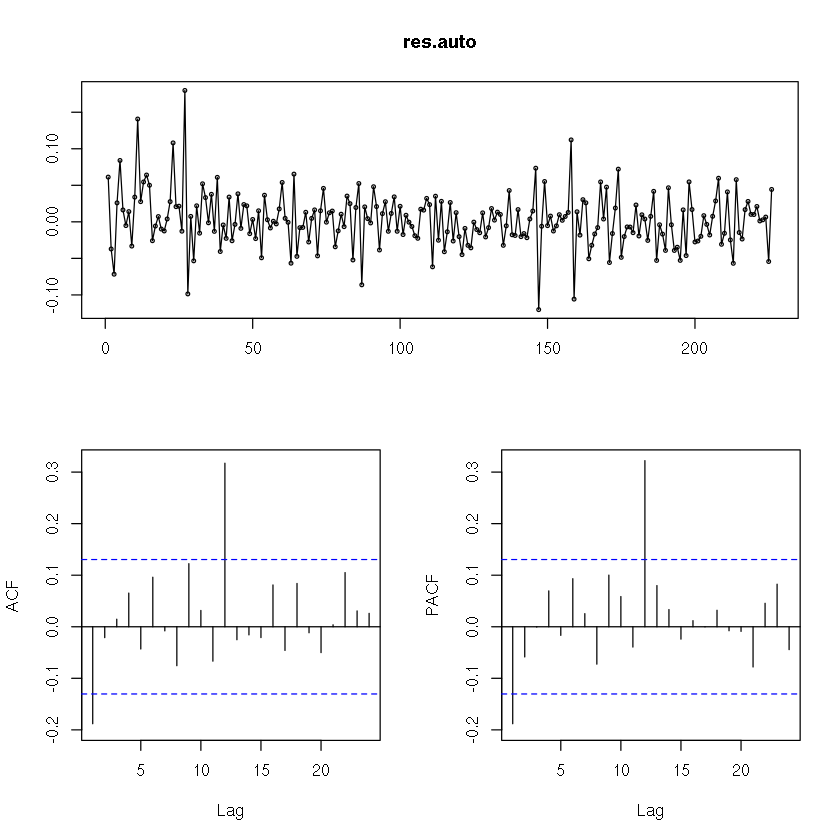

In [9]:
res.auto <- res.auto[-c(1:70)]
tsdisplay(res.auto)

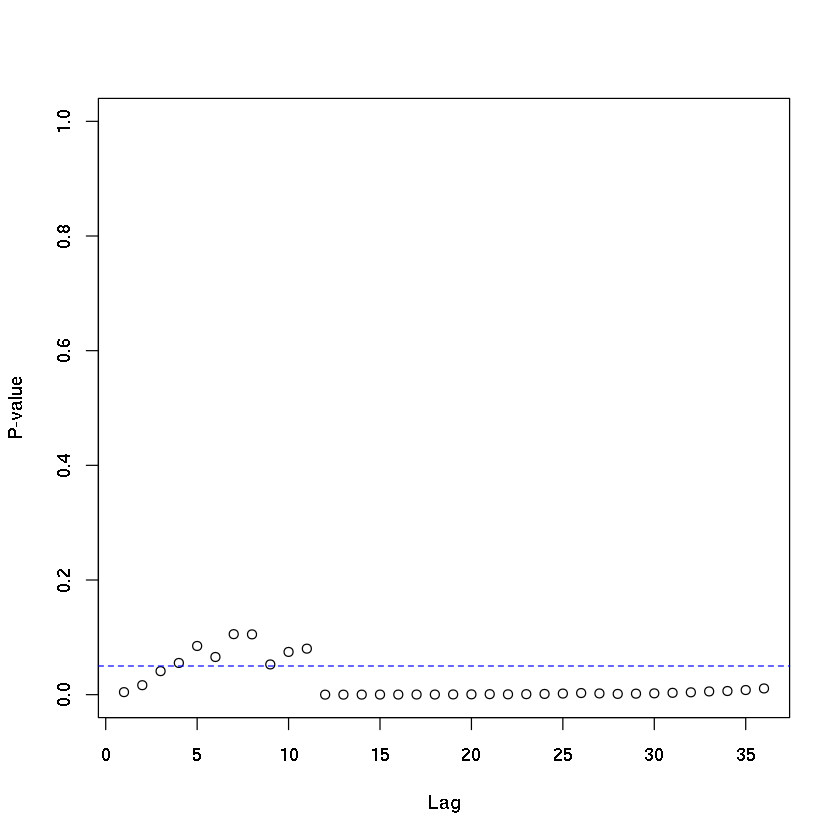

In [10]:
p <- rep(0, 1, frequency(tSeries)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(res.auto, lag=i, type = "Ljung-Box")$p.value
}
plot(p, xlab="Lag", ylab="P-value", ylim=c(0,1))
abline(h = 0.05, lty = 2, col = "blue")

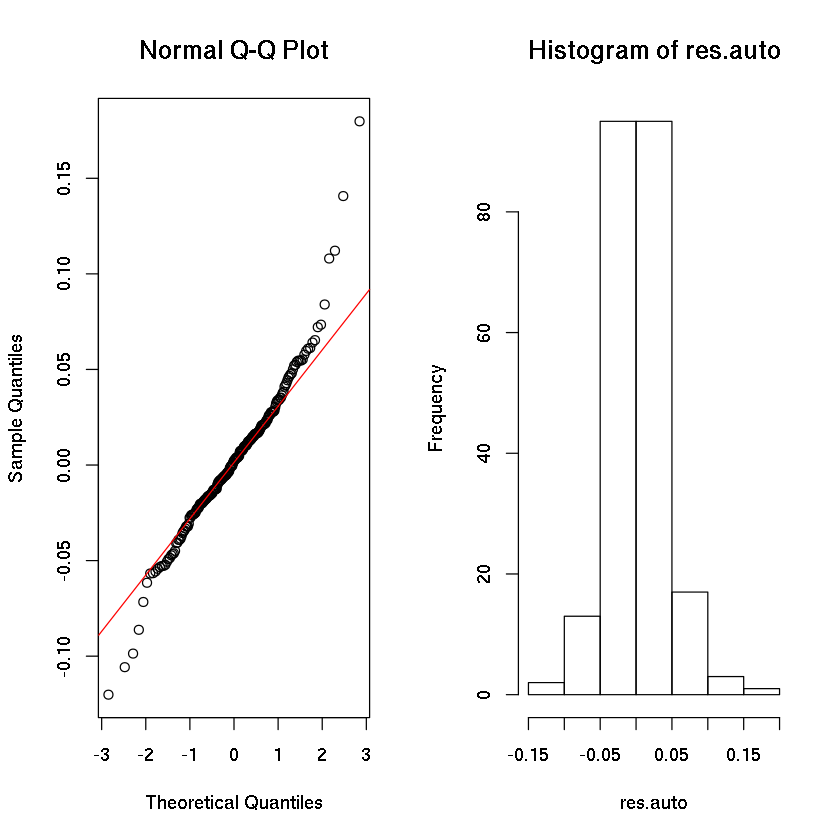

In [11]:
par(mfrow=c(1,2))
qqnorm(res.auto)
qqline(res.auto, col="red")
hist(res.auto)

In [12]:
p_value_shapiro = shapiro.test(res.auto)$p.value
p_value_wilcox = wilcox.test(res.auto)$p.value
p_value_kpss = kpss.test(res.auto)$p.value

Warning message in kpss.test(res.auto):
“p-value smaller than printed p-value”

Hypothesis     | Test           | Result          | p_value
-------------- | -------------- | --------------- | -------------------
Normality      | Shapiro–Wilk   | rejected        | {{p_value_shapiro}}
Unbiased       | Wilcoxon       | not rejected    | {{p_value_wilcox}}
Stationarity   | KPSS           | rejected        | {{p_value_kpss}}

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.07193322,3.83211,2.545853,-0.01343877,1.971086,0.181575,-0.1367122,NA
Test set,15.22565162,17.03058,15.225652,6.42529891,6.425299,1.085922,0.6659089,0.7451246


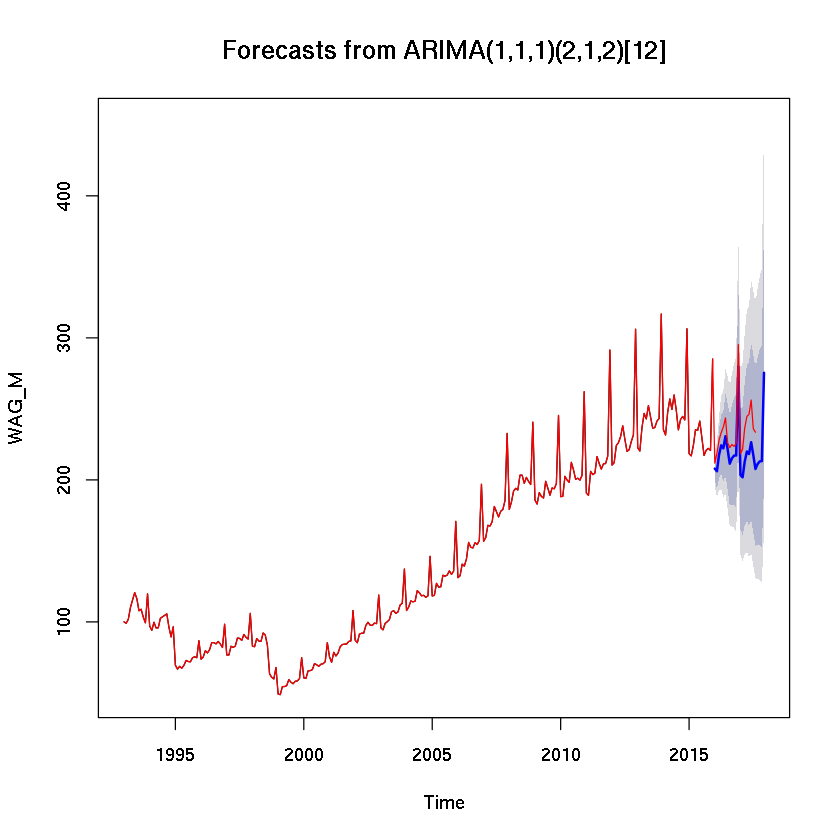

In [13]:
fitShort <- Arima(trainSeries, order=c(1,1,1), seasonal=c(2,1,2), lambda=LambdaOpt)
fc       <- forecast(fitShort, h=D)
accuracy(fc, testSeries)
plot(forecast(fitShort, h=D), ylab=xname, xlab="Time")
lines(tSeries, col="red")

### Manual selection

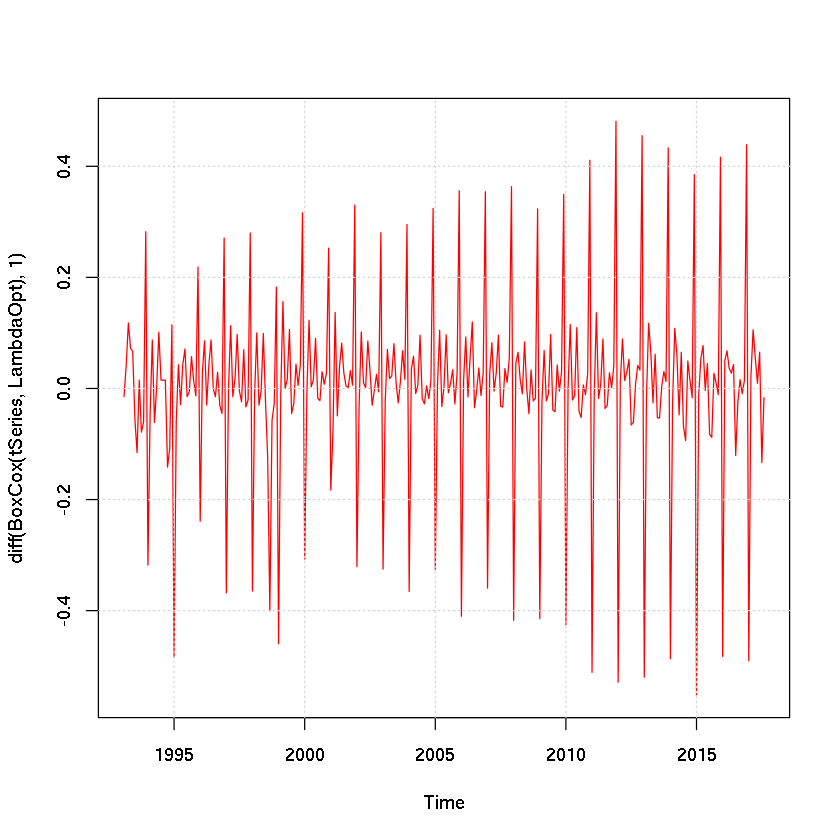

In [14]:
plot(diff(BoxCox(tSeries, LambdaOpt), 1), type="l", col="red")
grid()

In [15]:
p_value_kpss = kpss.test(diff(BoxCox(tSeries, LambdaOpt), 1))$p.value

Warning message in kpss.test(diff(BoxCox(tSeries, LambdaOpt), 1)):
“p-value greater than printed p-value”

Stationarity is **not rejected** because p_value > {{p_value_kpss}}

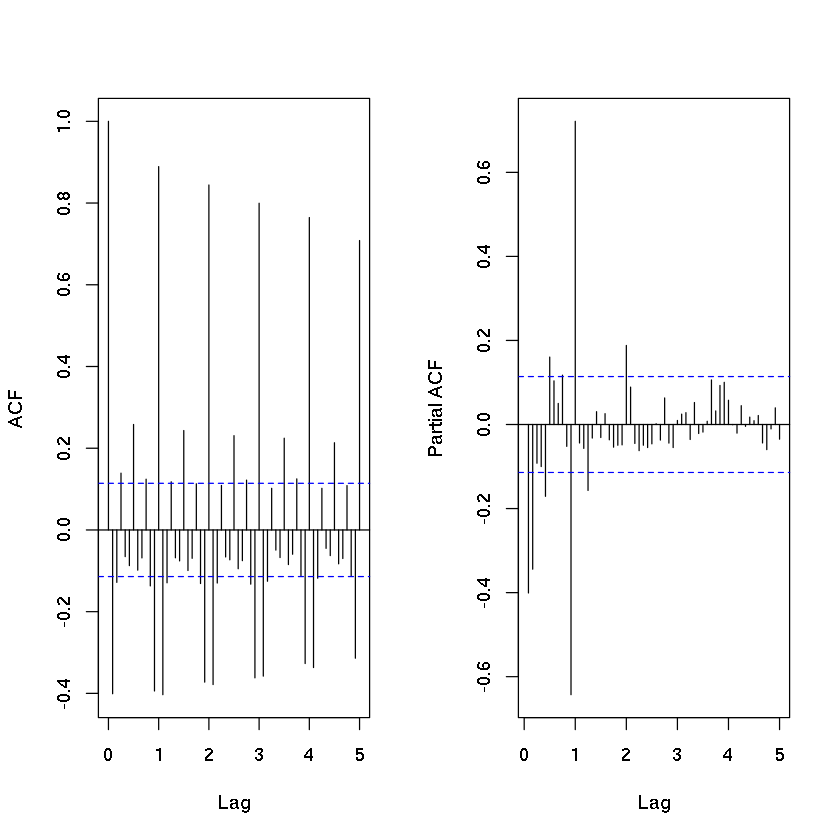

In [16]:
par(mfrow=c(1,2))
acf(diff(BoxCox(tSeries, LambdaOpt), 1), lag.max=5*12, main="")
pacf(diff(BoxCox(tSeries, LambdaOpt), 1), lag.max=5*12, main="")

In [17]:
fit <- auto.arima(tSeries, d=1, D=0, max.p=5, max.q=4, max.P=0, max.Q=2, max.order=10, lambda=LambdaOpt, stepwise=F)
fit

Series: tSeries 
ARIMA(3,1,4)(0,0,2)[12]                    
Box Cox transformation: lambda= 0.08800602 

Coefficients:
          ar1      ar2     ar3     ma1      ma2      ma3     ma4    sma1
      -0.5393  -0.0545  0.5921  0.3686  -0.0861  -0.5636  0.2901  0.7249
s.e.   0.1842   0.2207  0.1655  0.1903   0.1997   0.1274  0.0813  0.0639
        sma2
      0.6214
s.e.  0.0537

sigma^2 estimated as 0.006886:  log likelihood=312.09
AIC=-604.19   AICc=-603.41   BIC=-567.32

ARIMA(3, 1, 4)(0, 0, 2)[12] is suggested. <br>
It's residuals:

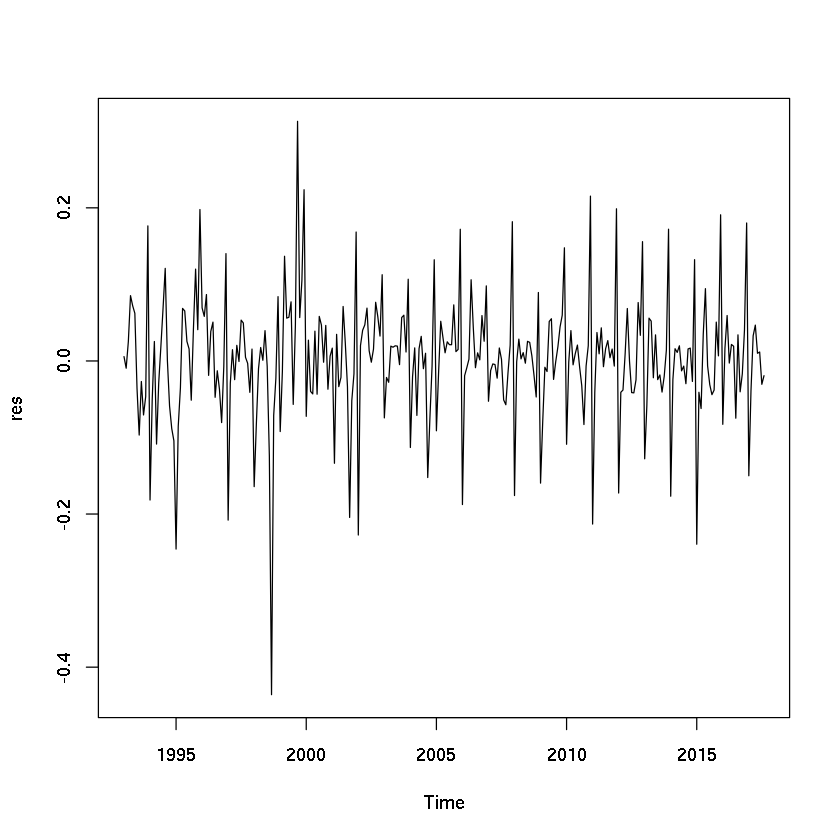

In [18]:
res <- residuals(fit)
plot(res)

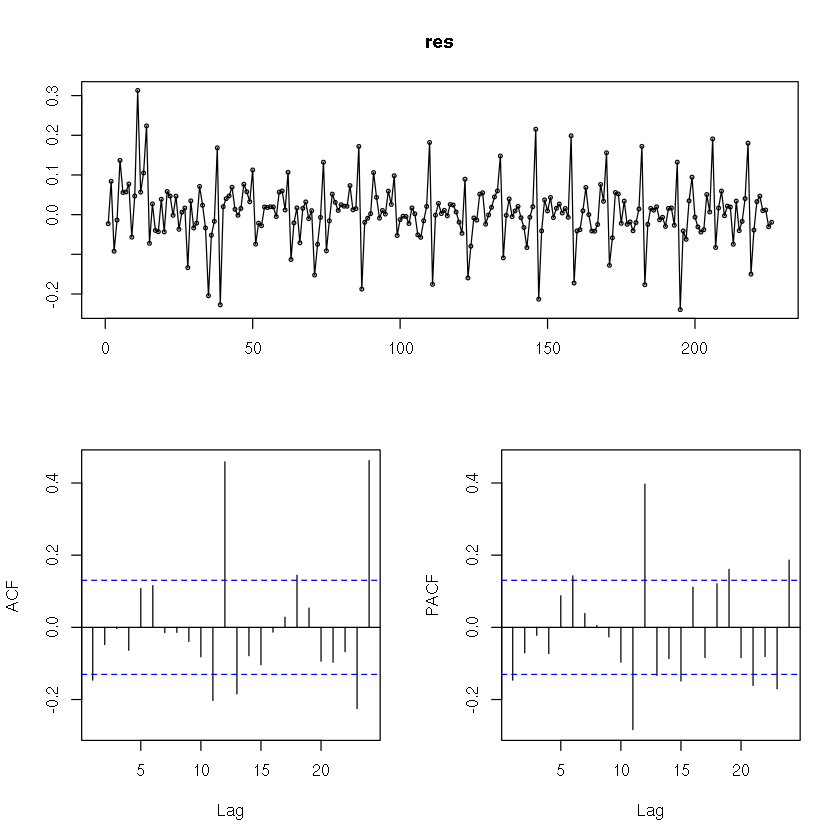

In [19]:
res <- res[-c(1:70)]
tsdisplay(res)

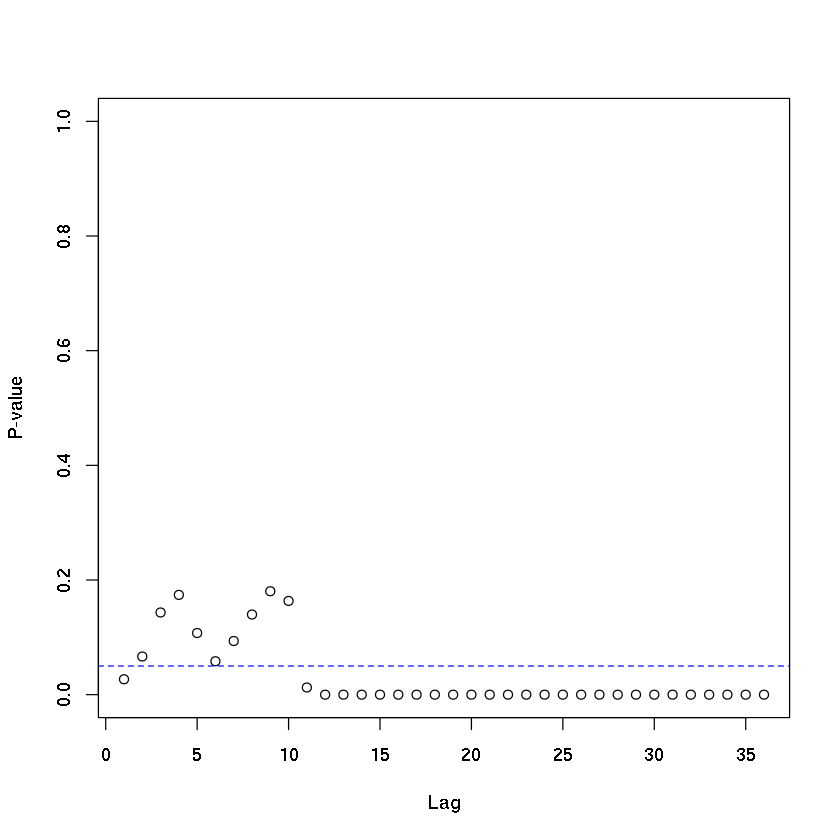

In [20]:
p <- rep(0, 1, frequency(tSeries)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(res, lag=i, type = "Ljung-Box")$p.value
}
plot(p, xlab="Lag", ylab="P-value", ylim=c(0,1))
abline(h = 0.05, lty = 2, col = "blue")

Q-Q plot and histogram:

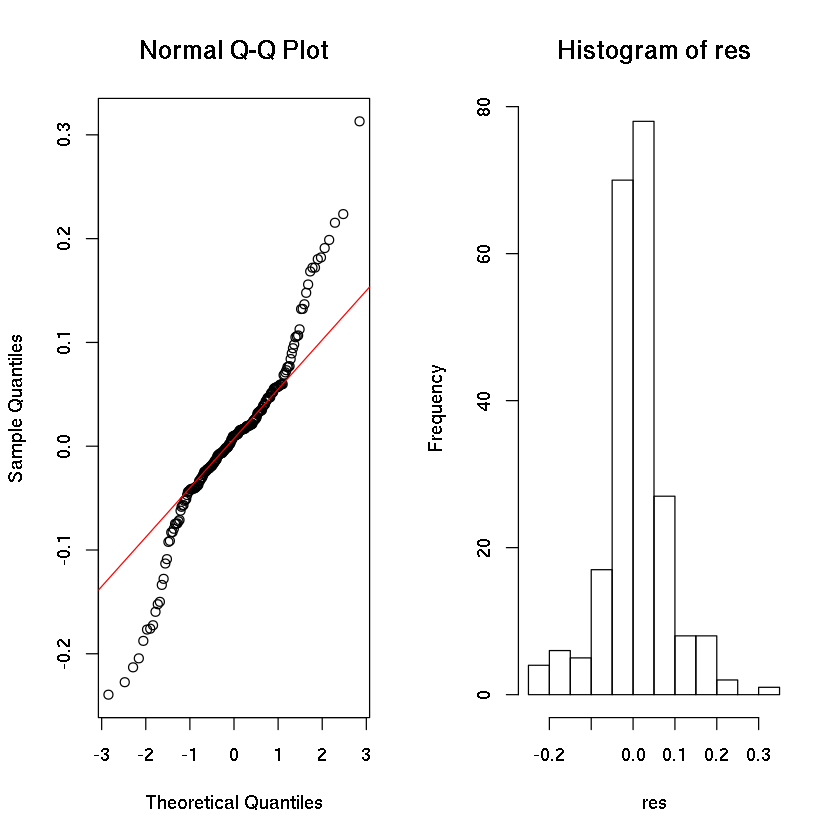

In [21]:
par(mfrow=c(1,2))
qqnorm(res)
qqline(res, col="red")
hist(res)

In [22]:
p_value_shapiro = shapiro.test(res)$p.value
p_value_wilcox = wilcox.test(res)$p.value
p_value_kpss = kpss.test(res)$p.value

Warning message in kpss.test(res):
“p-value greater than printed p-value”

Hypothesis     | Test           | Result          | p_value
-------------- | -------------- | --------------- | -------------------
Normality      | Shapiro–Wilk   | rejected        | {{p_value_shapiro}}
Unbiased       | Wilcoxon       | not rejected    | {{p_value_wilcox}}
Stationarity   | KPSS           | not rejected    | {{p_value_kpss}}

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.3381433,8.150289,5.021776,-0.005183975,3.679830,0.3581624,-0.1912477,NA
Test set,-1.3183840,9.816487,7.138653,-0.831795778,2.988344,0.5091420,-0.1063121,0.4179593


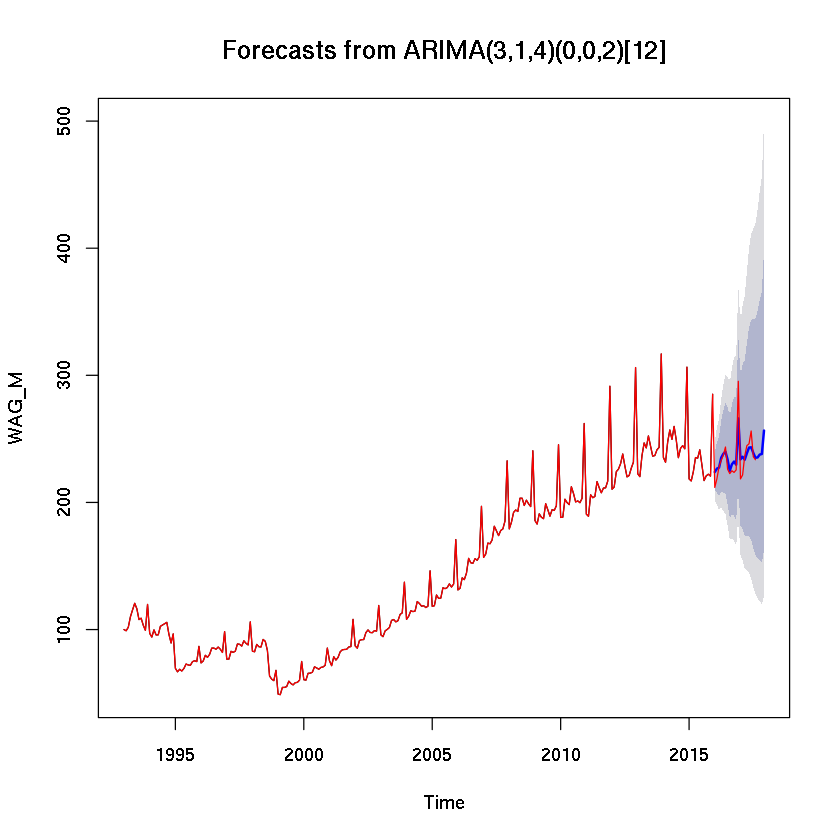

In [23]:
fitShort <- Arima(trainSeries, order=c(3,1,4), seasonal=c(0,0,2), lambda=LambdaOpt)
fc       <- forecast(fitShort, h=D)
accuracy(fc, testSeries)
plot(forecast(fitShort, h=D), ylab=xname, xlab="Time")
lines(tSeries, col="red")

### Comparison


	Diebold-Mariano Test

data:  resres.auto
DM = 5.125, Forecast horizon = 1, Loss function power = 2, p-value =
6.399e-07
alternative hypothesis: two.sided


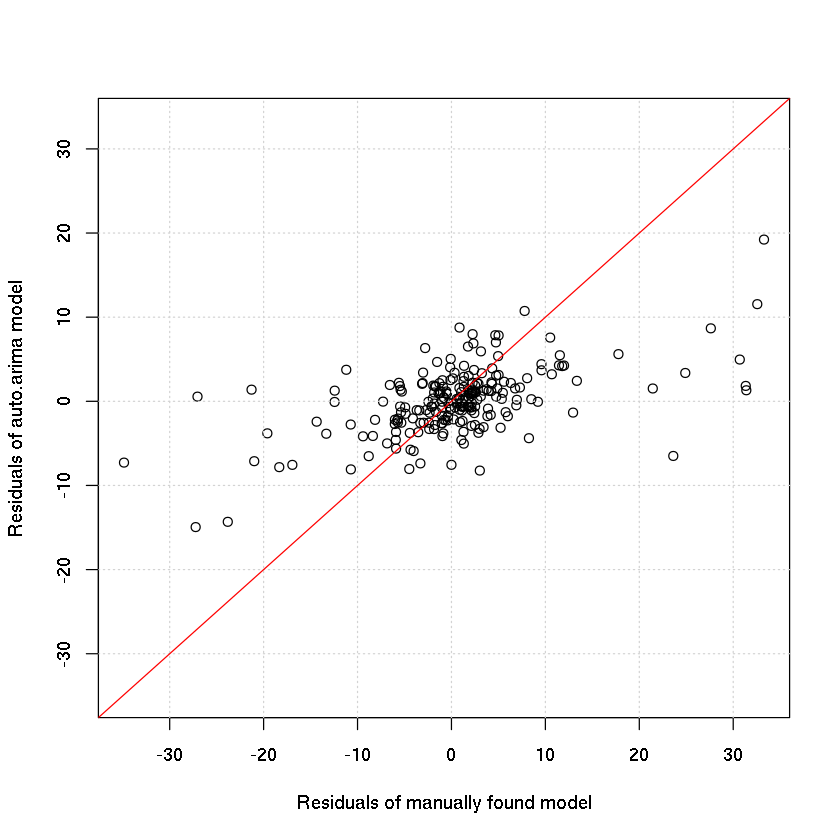

In [24]:
res      <- (tSeries - fitted(fit))[-c(1:70)]
res.auto <- (tSeries - fitted(fit.auto))[-c(1:70)]

plot(res, res.auto, xlim=c(min(res, res.auto), max(res, res.auto)), ylim=c(min(res, res.auto), max(res, res.auto)), 
     xlab = "Residuals of manually found model", ylab="Residuals of auto.arima model")
grid()
lines(c(min(res, res.auto), max(res, res.auto))*2, c(min(res, res.auto), max(res, res.auto))*2, col="red")

dm.test(res, res.auto)

p_value < 0.05 <br> 
Models differ significantly!

## Conclusion

Our manual model performs better. <br>
It has unbiased	and stationary errors. <br>
So let's choose this model as our final model.

## Result

Warning message in InvBoxCox(pred$pred, lambda, biasadj, var(residuals(object), :
“biasadj information not found, defaulting to FALSE.”

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Sep 2017       235.8030 223.7120 246.8705 209.5748 262.4942
Oct 2017       232.9382 214.3518 251.1179 202.5820 264.0058
Nov 2017       236.9173 215.1788 259.1956 201.2373 274.9915
Dec 2017       281.0784 252.7308 311.6958 232.5903 332.5599
Jan 2018       239.5489 210.3719 271.0051 192.3753 290.4740
Feb 2018       244.0306 211.7391 279.4963 193.7402 300.5458
Mar 2018       259.5178 222.4524 300.7540 202.6879 326.1967
Apr 2018       260.8962 220.9580 305.7333 196.4820 334.9153
May 2018       260.6718 218.1885 309.3098 194.3423 339.0028
Jun 2018       268.0211 222.1718 321.2864 197.5552 354.2802
Jul 2018       254.7828 208.0876 308.3577 183.3710 343.5248
Aug 2018       257.7954 210.5966 314.6638 184.0131 349.5240
Sep 2018       257.6496 203.0474 323.2946 174.4776 367.1593
Oct 2018       253.6763 195.7991 325.6127 166.2728 371.6185
Nov 2018       257.5201 194.7622 337.3863 164.4747 385.7668
Dec 2018       278.1389 206.5012 369.662

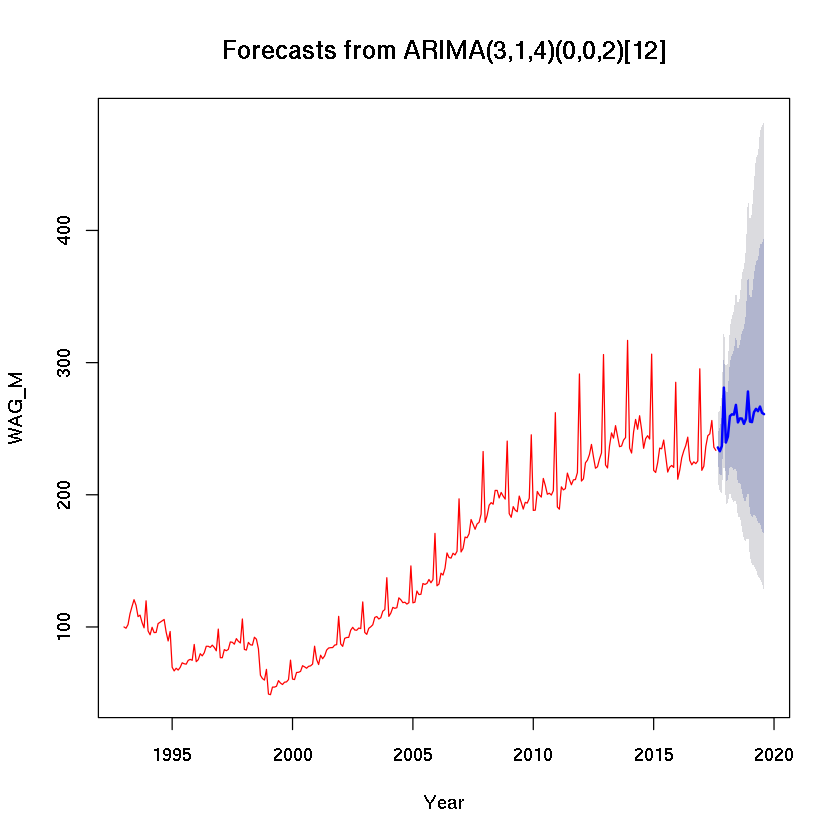

In [25]:
fl <- forecast(fit, h=D, lambda=LambdaOpt, bootstrap = T)
print(fl)
plot(fl, ylab=xname, xlab="Year", col="red")